In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import os
import sys
sys.path.append('../../ieegpy/ieeg')
sys.path.append('code/tools')

%matplotlib inline
import matplotlib.pyplot as plt
# sets path to one directory up from where code is
path = "/".join(os.path.abspath(os.getcwd()).split('/')[:-1])

import json
import numpy as np
from get_iEEG_data import get_iEEG_data
from plot_iEEG_data import plot_iEEG_data
from line_length import line_length
from get_iEEG_duration import get_iEEG_duration
from plot_iEEG_data_2 import plot_iEEG_data_2

In [99]:
with open("credentials.json") as f:
    credentials = json.load(f)
    username = credentials['username']
    password = credentials['password']

iEEG_filename = "HUP172_phaseII"
start_time_usec = 402580 * 1e6
stop_time_usec = 402800 * 1e6
electrodes = ["LE10","LE11","LH01","LH02","LH03","LH04"]

In [100]:
data, fs = get_iEEG_data(username, password, iEEG_filename, start_time_usec, stop_time_usec, select_electrodes=electrodes)
t_sec = np.linspace(start_time_usec, stop_time_usec, num=data.shape[0]) / 1e6

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Time (s)'>)

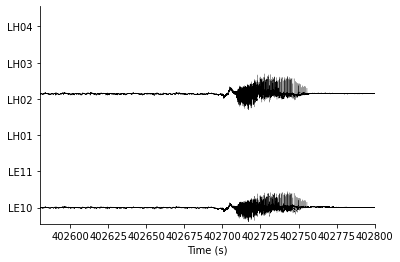

In [101]:
plot_iEEG_data(data,t_sec)

Text(0.5, 0, 'Clip Time (sec)')

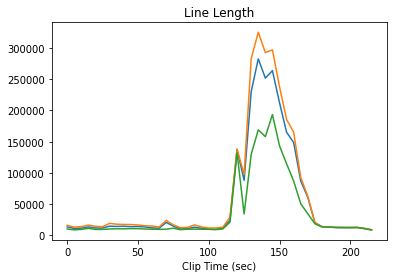

In [35]:
win_size_sec = 5

win_size_ind = int(win_size_sec * fs)

start_range = np.arange(0, len(data), win_size_ind, dtype=int)

ll_arr = np.zeros((len(start_range),data.shape[1]))
for i, start_ind in enumerate(start_range):
    ll_arr[i] = line_length(data[start_ind:(start_ind + win_size_ind)])

fig, ax = plt.subplots()
ax.plot(start_range/fs, ll_arr)
ax.set_title("Line Length")
ax.set_xlabel("Clip Time (sec)")

In [ ]:
get_iEEG_duration(username, password, iEEG_filename)